In [1]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm
import seaborn as sns
import pandas as pd

from denovo_utils.data.run import read_runs

2025-08-18 13:54:39.548469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-18 13:54:39.642394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-18 13:54:39.667350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


# Orbitrap metaproteomics

In [2]:
root_denovo_output = '/public/compomics3/Sam/PXD023217/denovo_output'
root_mgf = '/public/compomics3/Sam/PXD023217/mgf_filtered'
root_ground_truth = '/public/compomics3/Sam/PXD023217/rescoring'

# The other files should be rerun with ContraNovo due to bad spectrum_id parsing
filenames = [
    # 'F01_Fraction1',
    'F01_Fraction2',
    'F01_Fraction3',
    'F01_Fraction4',
    'S03',
    'S05',
    'S07',
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

root_refinement = ''

format_ground_truth = 'parquet'

rescored_db = True
rescored_denovo = False
rescored_refinement = False

# runs = {}
# for run_name in run_names_orbitrap:
#     print(f"Run: {run_name}")
#     run = Run(run_name)

#     mgf_path = os.path.join(root_mgf, run_name + '.mgf')

#     parser = DenovoEngineConverter.select('sage')
#     psmlist_gt = parser.parse(
#         result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
#         mgf_path=mgf_path
#     )
#     run.load_data(
#         psmlist=psmlist_gt.get_rank1_psms(),
#         score_names=[],
#         is_ground_truth=True
#     )

#     for engine_name in engine_names:
#         print(f'loading {engine_name}')
#         parser = DenovoEngineConverter.select(engine_name)
#         psmlist_denovo = parser.parse(
#             result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
#             mgf_path=mgf_path
#         )
#         run.load_data(
#             psmlist=psmlist_denovo,
#             score_names=[],
#             is_ground_truth=False
#         )
    
#     runs[run_name] = run

In [3]:
runs = read_runs(
    root_denovo_output=root_denovo_output,
    root_ground_truth=root_ground_truth,
    root_refinement='',
    root_mgf=root_mgf,
    filenames=filenames,
    engine_names=engine_names,
    refinement_names=[],
    format_ground_truth=format_ground_truth,
    rescored_db=rescored_db,
    rescored_denovo=rescored_denovo,
    rescored_refinement=rescored_refinement
)

Loading PSMs in Run object (S07): 100%|██████████| 46808/46808 [00:01<00:00, 38116.64it/s]


In [4]:
for run in runs.values():
    for spectrum in run.spectra.values():
        spectrum.compare_gt(
            'sage',
            ignore_score=True
        )
denovo_engines = ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo', 'pi-PrimeNovo', 'AdaNovo', 'pi-HelixNovo']

In [12]:
from denovo_utils.io.save import save_pickle

save_pickle(
    runs,
    path='/public/compomics3/Sam/PXD023217/run_objects_7_9.pickle'
)

In [2]:
from denovo_utils.io.read import load_pickle

runs = load_pickle('/public/compomics3/Sam/PXD023217/run_objects_7_9.pickle')

In [3]:
runs

{'F01_Fraction2': 39662 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).,
 'F01_Fraction3': 28809 spectra loaded from 8 engines (['pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'AdaNovo', 'contranovo']).,
 'F01_Fraction4': 20609 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).,
 'S03': 82757 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).,
 'S05': 115149 spectra loaded from 8 engines (['pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'AdaNovo', 'contranovo']).,
 'S07': 23574 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).}

In [5]:
len(runs)

6

In [25]:
from copy import deepcopy
from itertools import chain

modifications = {
    'UNIMOD:35': [],
    'UNIMOD:1': [],
    'UNIMOD:385': [],
    'Q[UNIMOD:7]': [],
    'N[UNIMOD:7]': [],
    'UNIMOD:5': [],
    'Formula:H-2C1O1': []
}

modifications_per_run = {
    k: deepcopy(modifications) for k in runs.keys()
}

for run_name, run in runs.items():
    for spectrum_id, spectrum in run.spectra.items():
        modifications_ = modifications_per_run[run_name]
        gt_peptide = spectrum.psm_gt.peptidoform.modified_sequence
        for modification, l in modifications_.items():
            if modification in gt_peptide:
                l.append(spectrum_id)

# Delete pepnet predictions for spectra with modifications outside pepnets search space
for run_name, run in runs.items():
    modified_spectra = set(chain(*list(modifications_per_run[run_name].values())))
    for spectrum_id, spectrum in run.spectra.items():
        if spectrum_id in modified_spectra:
            spectrum.psm_candidates = [i for i in spectrum.psm_candidates if i.engine_name != 'pepnet']

{
    k: {k2: len(v2) for k2, v2 in v.items()}
    for k, v in modifications_per_run.items()
}

{'F01_Fraction2': {'UNIMOD:35': 4220,
  'UNIMOD:1': 0,
  'UNIMOD:385': 0,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 0,
  'Formula:H-2C1O1': 0},
 'F01_Fraction3': {'UNIMOD:35': 6178,
  'UNIMOD:1': 0,
  'UNIMOD:385': 0,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 0,
  'Formula:H-2C1O1': 0},
 'F01_Fraction4': {'UNIMOD:35': 5907,
  'UNIMOD:1': 0,
  'UNIMOD:385': 0,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 0,
  'Formula:H-2C1O1': 0},
 'S03': {'UNIMOD:35': 11336,
  'UNIMOD:1': 0,
  'UNIMOD:385': 0,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 0,
  'Formula:H-2C1O1': 0},
 'S05': {'UNIMOD:35': 19424,
  'UNIMOD:1': 0,
  'UNIMOD:385': 0,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 0,
  'Formula:H-2C1O1': 0},
 'S07': {'UNIMOD:35': 1542,
  'UNIMOD:1': 0,
  'UNIMOD:385': 0,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 0,
  'Formula:H-2C1O1': 0}}

In [26]:
def get_match_score_tables(runs, common_spectra=True):

    tables_by_run = {}
    for filename, run in runs.items():
        if common_spectra:
            run_engine = run.get_common_spectra(engines=denovo_engines)

        tables = {}
        for engine in denovo_engines:
            if not common_spectra:
                run_engine = run.get_common_spectra([engine])
            t = get_match_score_table(
                {filename: run_engine},
                engine=engine,
                score_metadata=engine,
                eval_score_metadata='sage',
                refiner=None,
                return_table=True
            )
            tables[engine] = t

        tables_by_run[filename] = tables
    
    pr_tables = {engine: [] for engine in denovo_engines}
    for filename, tables in tables_by_run.items():
        for engine, table in tables.items():
            pr_tables[engine].append(table)
    
    pr_tables = {engine: pd.concat(tables, ignore_index=True) for engine, tables in pr_tables.items()}
    return pr_tables

In [27]:
pr_tables_common_spectra = get_match_score_tables(runs=runs, common_spectra=True)
pr_tables_all_spectra = get_match_score_tables(runs=runs, common_spectra=False)

In [17]:
pr_tables_common_spectra.keys()

dict_keys(['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo', 'pi-PrimeNovo', 'AdaNovo', 'pi-HelixNovo'])

In [18]:
[len(i) for engine, i in pr_tables_common_spectra.items()]

[147310, 147310, 147310, 147310, 147310, 147310, 147310, 147310]

In [19]:
[len(i) for engine, i in pr_tables_all_spectra.items()]

[308334, 302882, 303730, 310558, 154790, 309244, 154080, 309233]

In [28]:
from denovo_utils.analysis.metrics import calculate_prc
import numpy as np

def calculate_prc(
        n_correct,
        n_selected,
        n_predicted
):
    c = n_correct
    ci = n_selected
    u = n_predicted - ci

    # precision
    precision = c/ci

    # recall (This is an alternative definition and the line will stop at x=y)
    recall = c/n_predicted

    # coverage
    coverage = ci/n_predicted

    return precision, recall, coverage


def get_prc_curve(t, n_predicted = None):
    prs = []
    recs = []
    covs = []

    t = t.sort_values('score', ascending=False).reset_index(drop=True)

    if n_predicted is None:
        n_predicted = len(t)

    for coverage in tqdm(np.linspace(0,1,200)):
        if coverage == 0:
            continue
        n_samples = coverage * len(t)
        samples_evaluated = t[t.index<n_samples]
        
        pr, rec, cov = calculate_prc(
            n_correct=len(samples_evaluated[samples_evaluated.match]),
            n_selected=len(samples_evaluated),
            n_predicted=n_predicted,
        )
        prs.append(pr)
        recs.append(rec)
        covs.append(cov)

    return pd.DataFrame(
        {'precision': prs,
         'recall': recs,
         'coverage': covs}
    )

In [29]:
# Calculate precision recall coverage when defined on common spectra
pr_rec_cov_dict = {}
for engine, tables in pr_tables_common_spectra.items():
    
    # total predicted here means all common spectra (shape of very df here)
    prc = get_prc_curve(tables)
    pr_rec_cov_dict[engine] = {
        'precision': prc.precision.to_numpy(),
        'recall': prc.recall.to_numpy(),
        'coverage': prc.coverage.to_numpy()
    }

# Calculate precision recall coverage on complete set of database results
# total predicted here means all db results
n_spectra = sum([len(i) for i in runs.values()])

all_db_peptides = sum([len(run.spectra.keys()) for run in runs.values()])
pr_rec_cov_dict_all = {}
for engine, tables in pr_tables_all_spectra.items():
    prc = get_prc_curve(tables, n_spectra)
    pr_rec_cov_dict_all[engine] = {
        'precision': prc.precision.to_numpy(),
        'recall': prc.recall.to_numpy(),
        'coverage': prc.coverage.to_numpy()
    }

100%|██████████| 200/200 [00:02<00:00, 70.95it/s] 


plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


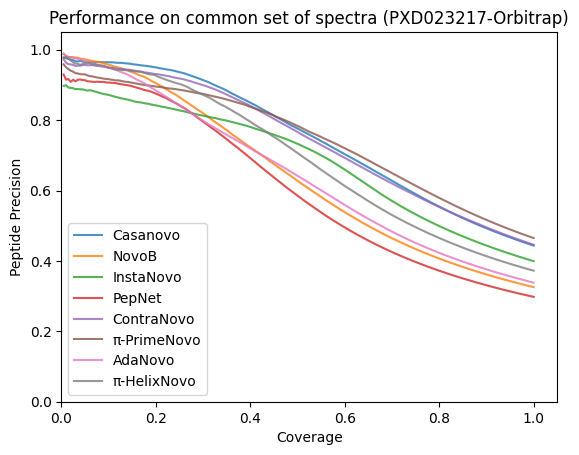

casanovo
novob
instanovo
pepnet
contranovo
pi-PrimeNovo
AdaNovo
pi-HelixNovo


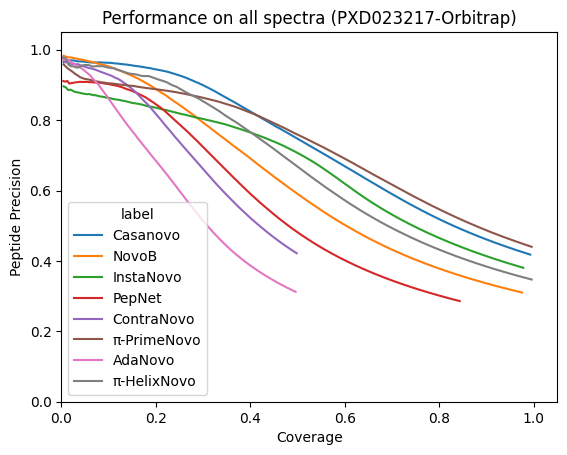

In [31]:
# plotting a precision coverage curve
engine_labels = {
    'pepnet': 'PepNet',
    'novob': 'NovoB',
    'instanovo': 'InstaNovo',
    'casanovo': 'Casanovo',
    'contranovo': 'ContraNovo',
    'AdaNovo': 'AdaNovo',
    'pi-PrimeNovo': 'π-PrimeNovo',
    'pi-HelixNovo': 'π-HelixNovo'
}

# plotting a precision coverage curve
for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine_labels[engine],   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD023217-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')
plt.show()

pr_tables = []
for engine, pr_dict in pr_rec_cov_dict_all.items():
    pr_table = pd.DataFrame(
        {'coverage': pr_dict['coverage'],
         'precision': pr_dict['precision']}
    )
    print(engine)
    pr_table['model'] = engine
    pr_tables.append(
        pr_table
    )
pr_tables = pd.concat(pr_tables, ignore_index=True)

hue_order = [
    'casanovo',
    'novob',
    'instanovo',
    'pepnet',
    'contranovo',
    'pi-PrimeNovo',
    'AdaNovo',
    'pi-HelixNovo'
]
pr_tables['label'] = pr_tables['model'].apply(lambda x: engine_labels[x])

sns.lineplot(
    pr_tables,
    x='coverage',
    y='precision',
    hue='label',
    hue_order=[engine_labels[h] for h in hue_order]
)
plt.title("Performance on all spectra (PXD023217-Orbitrap)")
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')
plt.show()

casanovo
novob
instanovo
pepnet
contranovo
pi-PrimeNovo
AdaNovo
pi-HelixNovo


Text(0, 0.5, 'Peptide Precision')

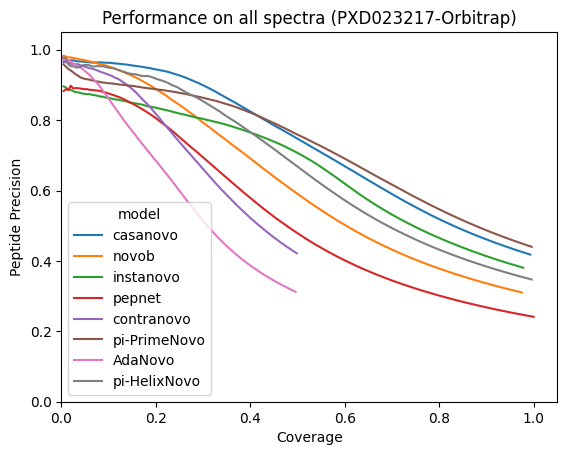

In [24]:
pr_tables = []
for engine, pr_dict in pr_rec_cov_dict_all.items():
    pr_table = pd.DataFrame(
        {'coverage': pr_dict['coverage'],
         'precision': pr_dict['precision']}
    )
    print(engine)
    pr_table['model'] = engine
    pr_tables.append(
        pr_table
    )
pr_tables = pd.concat(pr_tables, ignore_index=True)

hue_order = [
    'casanovo',
    'novob',
    'instanovo',
    'pepnet',
    'contranovo',
    'pi-PrimeNovo',
    'AdaNovo',
    'pi-HelixNovo'
]

sns.lineplot(
    pr_tables,
    x='coverage',
    y='precision',
    hue='model',
    hue_order=hue_order
)
plt.title("Performance on all spectra (PXD023217-Orbitrap)")
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


Text(0, 0.5, 'Peptide Precision')

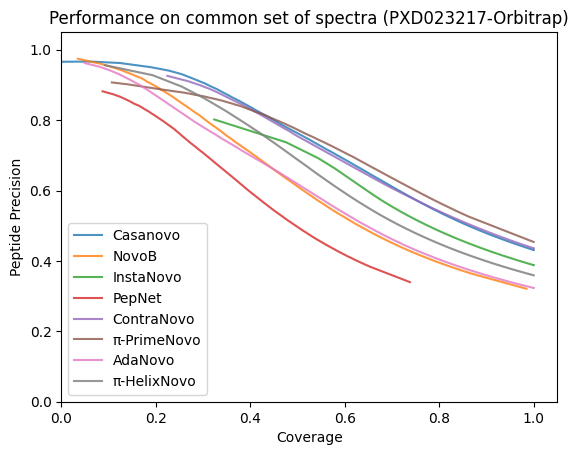

In [11]:
# plotting a precision coverage curve
engine_labels = {
    'pepnet': 'PepNet',
    'novob': 'NovoB',
    'instanovo': 'InstaNovo',
    'casanovo': 'Casanovo',
    'contranovo': 'ContraNovo',
    'AdaNovo': 'AdaNovo',
    'pi-PrimeNovo': 'π-PrimeNovo',
    'pi-HelixNovo': 'π-HelixNovo'
}

# plotting a precision coverage curve
for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine_labels[engine],   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD023217-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo


Text(0, 0.5, 'Peptide Precision')

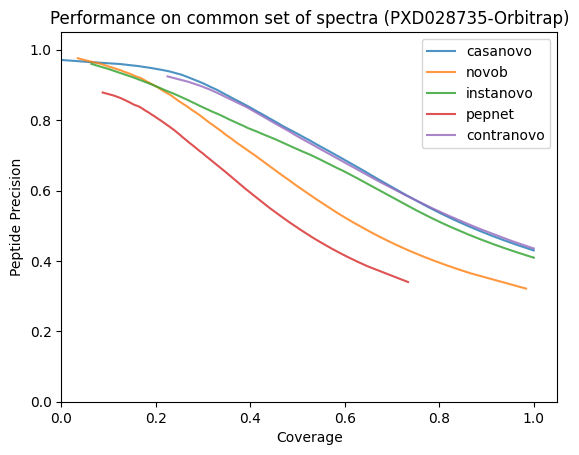

In [27]:
# plotting a precision coverage curve
for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

Barplot

In [28]:
barplot_data = {
    'engine': [],
    'run': [],
    'precision': [],
    'coverage': []
}

for engine in denovo_engines:
    engine_performance = {}

    for run_name, run in runs.items():

        n_all = len(run.spectra)
        run_engine = run.get_common_spectra(engines=[engine])
        n_predicted = len(run_engine.spectra)
        n_correct = 0
        for spectrum in run_engine.spectra.values():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['sage'].error_type=="match":
                n_correct += 1

        coverage = n_predicted/n_all
        precision = n_correct/n_predicted
        
        barplot_data['coverage'].append(coverage)
        barplot_data['precision'].append(precision)
        barplot_data['engine'].append(engine)
        barplot_data['run'].append(run_name)

In [29]:
barplot_data = pd.DataFrame(barplot_data).sort_values(by='precision')

In [30]:
def plot_precision_coverage_barplot(barplot_data):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the first barchart (pointing to the right)
    bar1 = sns.barplot(data=barplot_data, y='run', x='precision', hue='engine', ax=ax)

    # Plot the second barchart (pointing to the left)
    bar2 = sns.barplot(data=barplot_data, y='run', x=[-v for v in barplot_data['coverage']], hue='engine', ax=ax)

    # Add the vertical line at x=0
    ax.axvline(0, color='black', linewidth=1)

    # Customize the plot
    ax.set_ylabel('Sample type')

    # Set x-axis limits to ensure symmetry
    max_val = max(max(barplot_data['precision']), max(barplot_data['coverage']))
    ax.set_xlim(-int(max_val), int(max_val))
    ax.set_xticks(range(-int(max_val), int(max_val) + 1, 5))

    # Remove default x-axis label
    ax.set_xlabel('')

    # Add custom x-axis labels for Precision and Coverage
    ax.text(max_val / 2, -0.7, 'Precision', va='center', ha='center', fontsize=12)
    ax.text(-max_val / 2, -0.7, 'Coverage', va='center', ha='center', fontsize=12)

    # Adjust the legend to appear outside the plot
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict(zip(labels, handles)).items())
    ax.legend(
        [handle for _, handle in unique_labels],
        [label for label, _ in unique_labels],
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        title="De novo tool"
    )

    for p in bar1.patches:
        width = p.get_width()  # Get the width of the bar
        percentage = (width / max_val) * 100  # Calculate the percentage of max width
        ax.annotate(f'{abs(percentage):.2f}%', (p.get_width(), p.get_y() + p.get_height() / 2),
                    va='center', ha='left', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

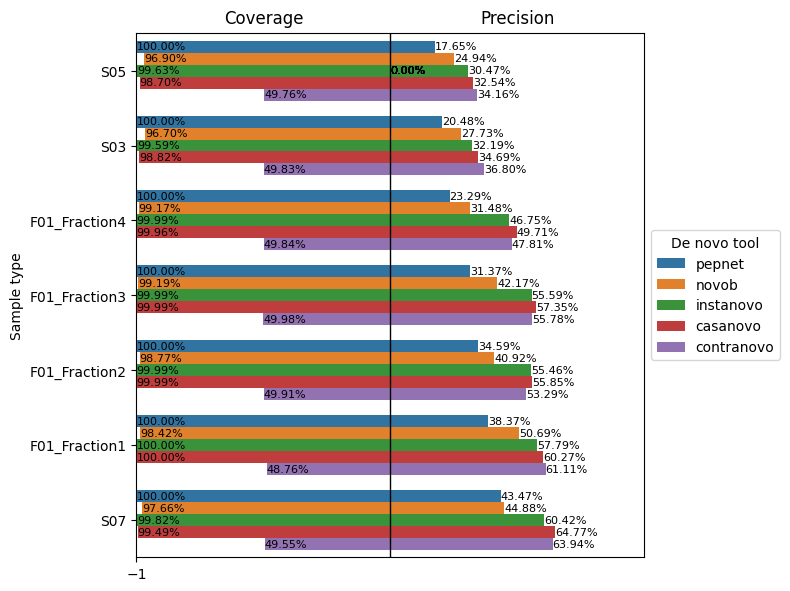

In [31]:
plot_precision_coverage_barplot(barplot_data)

# Metaproteomics timsTOF

In [33]:
run_names_timstof = [
    'F08_Rep1',
    'F08_Rep2'
]

runs_timstof = {}
for run_name in run_names_timstof:
    print(f"Run: {run_name}")
    run = Run(run_name)

    mgf_path = os.path.join(root_mgf, run_name + '.mgf')

    parser = DenovoEngineConverter.select('sage')
    psmlist_gt = parser.parse(
        result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
        mgf_path=mgf_path
    )
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=[],
        is_ground_truth=True
    )

    for engine_name in engine_names:
        print(f'loading {engine_name}')
        parser = DenovoEngineConverter.select(engine_name)
        psmlist_denovo = parser.parse(
            result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
            mgf_path=mgf_path
        )
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=[],
            is_ground_truth=False
        )
    
    runs_timstof[run_name] = run

Run: F08_Rep1


100%|██████████| 47356/47356 [00:00<00:00, 141508.42it/s]


loading casanovo


100%|██████████| 51130/51130 [00:00<00:00, 70599.25it/s]


loading instanovo


100%|██████████| 50058/50058 [00:14<00:00, 3566.72it/s]


loading contranovo


100%|██████████| 25544/25544 [00:00<00:00, 62964.15it/s]


loading novob


100%|██████████| 46854/46854 [00:00<00:00, 135684.82it/s]


loading pepnet


100%|██████████| 61489/61489 [00:01<00:00, 52773.37it/s]


Run: F08_Rep2


100%|██████████| 48063/48063 [00:00<00:00, 88415.21it/s]


loading casanovo


100%|██████████| 51429/51429 [00:01<00:00, 43900.93it/s]


loading instanovo


100%|██████████| 50405/50405 [00:00<00:00, 83544.61it/s]


loading contranovo


100%|██████████| 25681/25681 [00:00<00:00, 40969.20it/s]


loading novob


100%|██████████| 47411/47411 [00:00<00:00, 83670.95it/s]


loading pepnet


100%|██████████| 60567/60567 [00:01<00:00, 47416.77it/s]


In [34]:
for run in runs_timstof.values():
    for spectrum in run.spectra.values():
        spectrum.compare_gt(
            'sage',
            ignore_score=True
        )
denovo_engines = ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo']

In [35]:
pr_tables_common_spectra_timstof = get_match_score_tables(runs=runs_timstof, common_spectra=True)
pr_tables_all_spectra_timstof = get_match_score_tables(runs=runs_timstof, common_spectra=False)

In [36]:
# Calculate precision recall coverage when defined on common spectra
pr_rec_cov_dict_timstof = {}
for engine, tables in pr_tables_common_spectra_timstof.items():
    
    # total predicted here means all common spectra (shape of very df here)
    prc = get_prc_curve(tables, len(tables))
    pr_rec_cov_dict_timstof[engine] = {
        'precision': prc.precision.to_numpy(),
        'recall': prc.recall.to_numpy(),
        'coverage': prc.coverage.to_numpy()
    }

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo


Text(0, 0.5, 'Peptide Precision')

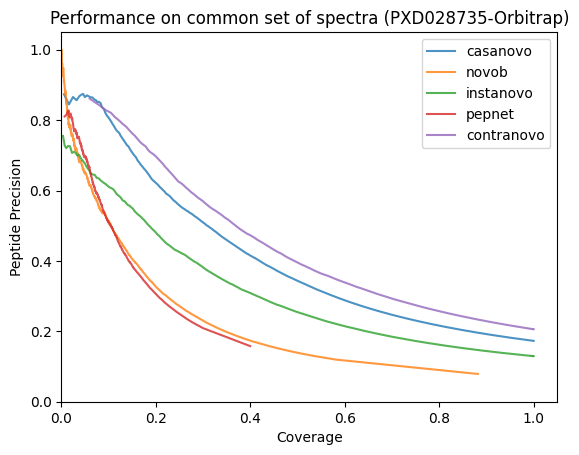

In [37]:
# plotting a precision coverage curve
for engine, pr_dict in pr_rec_cov_dict_timstof.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

In [38]:
barplot_data_timstof = {
    'engine': [],
    'run': [],
    'precision': [],
    'coverage': []
}

for engine in denovo_engines:
    engine_performance = {}

    for run_name, run in runs_timstof.items():

        n_all = len(run.spectra)
        run_engine = run.get_common_spectra(engines=[engine])
        n_predicted = len(run_engine.spectra)
        n_correct = 0
        for spectrum in run_engine.spectra.values():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['sage'].error_type=="match":
                n_correct += 1

        coverage = n_predicted/n_all
        precision = n_correct/n_predicted
        
        barplot_data_timstof['coverage'].append(coverage)
        barplot_data_timstof['precision'].append(precision)
        barplot_data_timstof['engine'].append(engine)
        barplot_data_timstof['run'].append(run_name)

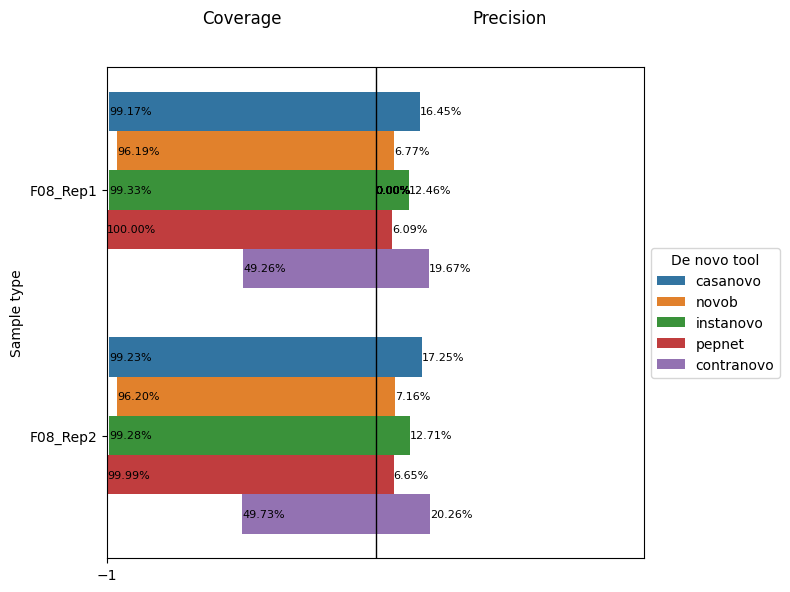

In [39]:
plot_precision_coverage_barplot(barplot_data_timstof)